<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Word2Vec-embedding-gensim" data-toc-modified-id="Word2Vec-embedding-gensim-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Word2Vec embedding gensim</a></span></li><li><span><a href="#tf-idf" data-toc-modified-id="tf-idf-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>tf-idf</a></span></li></ul></div>

In [137]:
# import basic libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
import os
# load the word2vec algorithm from the gensim library
from gensim.models import word2vec

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec, KeyedVectors 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance


In [19]:
import  multiprocessing 
multiprocessing.cpu_count() 

4

In [3]:
import torch

torch.cuda.get_device_name()

'GeForce GTX 950M'

# Word2Vec embedding gensim

In [ ]:
# load dataframes
l2q = pd.read_csv('l2q.csv', index_col=0)
l2a = pd.read_csv('l2a.csv', index_col=0)

In [4]:
# function to clean text
def process_words(raw_review):
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 3. Remove Stopwords. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  #returns a list 

    # 5. Stem words. Need to define porter stemmer above
    #meaningful_words = [stemmer.stem(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))

In [5]:

# build a corpus for the word2vec model
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)    
           
    return corpus

In [6]:
# Process the answers
processed_questions = [process_words(text) for text in l2q['questions_text']]

In [7]:
 l2q['questions_text'][0]

'What Does Medicare IME Stand For ?'

In [8]:
processed_questions[0]

'medicare ime stand'

In [125]:
# Build the corpus: transform sentences to list of words
corpus = build_corpus(processed_questions)
# Create word2vec embedding
w2v_embedding_q = word2vec.Word2Vec(corpus, size=100, window=5, min_count=50,workers=4)

In [126]:
# The most important 10 words 
print("The most important 10 words", w2v_embedding_q.wv.index2word[:10])

The most important 10 words ['insurance', 'life', 'health', 'cover', 'medicare', 'get', 'term', 'much', 'car', 'disability']


In [127]:
w2v_embedding_q.wv.most_similar('insurance')

[('cancel', 0.7579680681228638),
 ('someone', 0.7335457801818848),
 ('parents', 0.7191541194915771),
 ('claim', 0.7115480899810791),
 ('rates', 0.7046974301338196),
 ('get', 0.7033909559249878),
 ('check', 0.7026255130767822),
 ('cheap', 0.7000647783279419),
 ('new', 0.6954667568206787),
 ('quotes', 0.695258617401123)]

In [128]:
w2v_embedding_q.wv.most_similar('life')

[('policy', 0.8666777610778809),
 ('whole', 0.8381844758987427),
 ('level', 0.8089743852615356),
 ('surrender', 0.7919088006019592),
 ('value', 0.7897084355354309),
 ('universal', 0.7882015109062195),
 ('paid', 0.786618709564209),
 ('cash', 0.7853676080703735),
 ('happens', 0.7759577035903931),
 ('beneficiary', 0.7669820785522461)]

In [129]:
# The less important 10 words 
print("The less important 10 words", w2v_embedding_q.wv.index2word[-10:])

The less important 10 words ['personal', 'dog', 'include', 'primary', 'paying', 'probate', 'broken', 'needs', 'individual', 'loss']


Extract the embedding weights from the gensim Word2Vec embedding layer and store it in a numpy array, ready for use in TensorFlow and Keras.

In [130]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

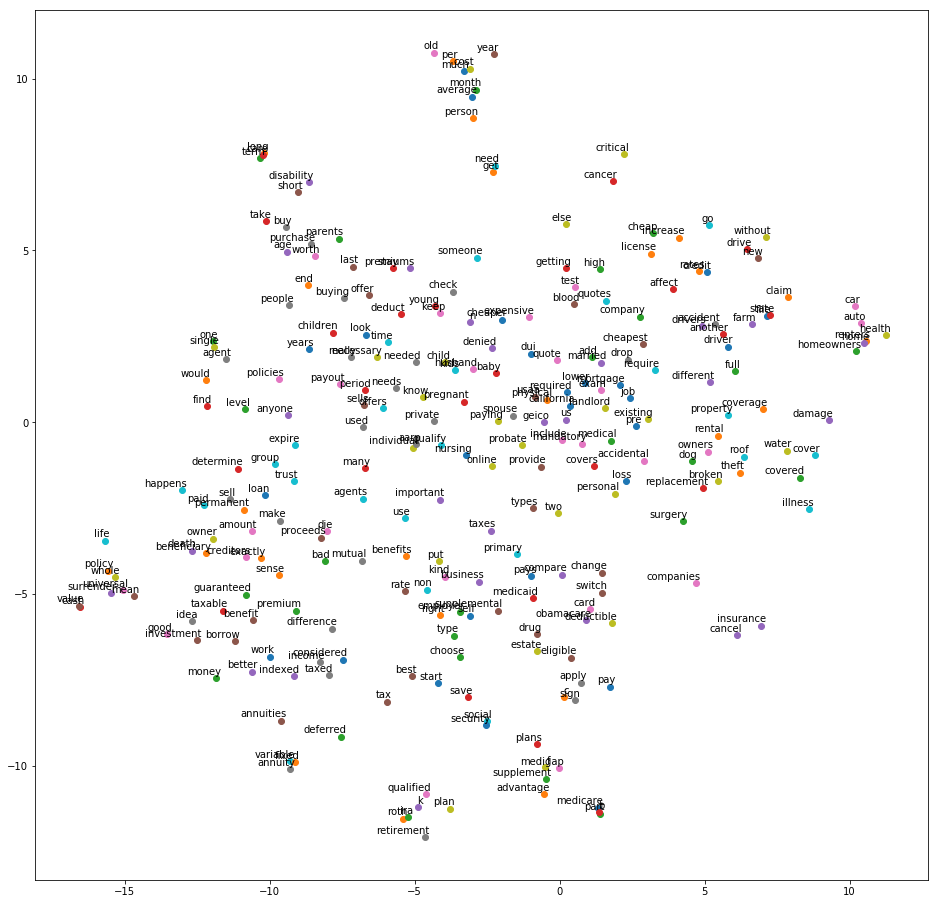

In [131]:
tsne_plot(w2v_embedding_q)

In [51]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
def create_embedding_matrix(model, vector_dim = 100):
    embedding_matrix = np.zeros((len(model.wv.vocab), vector_dim ))
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [52]:
embedding_matrix_q = create_embedding_matrix(w2v_embedding_q)

In [87]:
def sentence_vector(model, sentence):
    sentence_vec = 0
    for w in sentence:  
        try :
            # Sum the word vetcors 
            sentence_vec += model.wv.get_vector(w)
        except:
            pass
    return sentence_vec

In [89]:
sentence_vector(word2vec_embedding_q, corpus[0])

array([-0.01545988, -0.03587828, -0.12333541,  0.03110792,  0.17398274,
        0.20691715, -0.2382816 ,  0.08753082,  0.04619209, -0.2349918 ,
        0.1272372 ,  0.00162662, -0.27686122, -0.08420663,  0.01231242,
        0.00274119, -0.00112935, -0.18476325,  0.13084185, -0.28418577,
       -0.03582834,  0.1237925 ,  0.02175196,  0.00814705, -0.05686904,
       -0.17353216,  0.08699065,  0.11252544,  0.11143787,  0.03146474,
        0.12547186, -0.2899507 ,  0.11544665, -0.01096589, -0.01317981,
        0.31034437, -0.179116  ,  0.08880097,  0.07841061, -0.0405508 ,
       -0.10053977, -0.05293422, -0.15649101,  0.19096288,  0.23762095,
        0.00162879,  0.17413211,  0.15401587, -0.11554132, -0.14814532,
        0.04289303, -0.1287456 ,  0.27151138,  0.27050522,  0.16436613,
       -0.11128086, -0.09725952, -0.2027694 , -0.1468405 , -0.13044427,
       -0.06524184, -0.20989443, -0.00645624, -0.16258083,  0.17010161,
       -0.03892715, -0.29031655,  0.03769385,  0.08735982,  0.06

In [92]:
# Add corpus to dataframe
l2q['corpus'] = corpus

# tf-idf

In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity


def word_tokenizer(text):
    #tokenizes and stems the text
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
    return tokens

def construct_tfidf_matrix(sentences):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=process_words,
                                    stop_words=stopwords.words('english'))

    #builds a tf-idf matrix for the sentences
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

In [196]:
similarity_matrix = construct_tfidf_matrix(list(l2q['questions_text'])) 

In [197]:
# To have to compute so it's saved
#np.save('similarity_matrix', similarity_matrix)

In [189]:
similarity_matrix = np.load('similarity_matrix.npy')

In [199]:
# Similarity matrix dataframe
sm_df = pd.DataFrame(similarity_matrix)

In [201]:
sm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27977,27978,27979,27980,27981,27982,27983,27984,27985,27986
0,1.000000,0.839669,0.595145,0.814970,0.814970,0.788443,0.782038,0.740669,0.705482,0.649725,...,0.684614,0.863787,0.863787,0.864266,0.476117,0.476117,0.827886,0.827886,0.847456,0.823073
1,0.839669,1.000000,0.623080,0.816476,0.816476,0.683881,0.762593,0.750156,0.740375,0.682222,...,0.791295,0.802457,0.802457,0.826416,0.523190,0.523190,0.734201,0.734201,0.897014,0.749792
2,0.595145,0.623080,1.000000,0.565328,0.565328,0.508436,0.783907,0.726781,0.695589,0.889650,...,0.840253,0.722964,0.722964,0.665984,0.750605,0.750605,0.782660,0.782660,0.677972,0.758191
3,0.814970,0.816476,0.565328,1.000000,1.000000,0.722199,0.832468,0.733248,0.663726,0.589930,...,0.746941,0.889740,0.889740,0.800600,0.472883,0.472883,0.801296,0.801296,0.835069,0.823713
4,0.814970,0.816476,0.565328,1.000000,1.000000,0.722199,0.832468,0.733248,0.663726,0.589930,...,0.746941,0.889740,0.889740,0.800600,0.472883,0.472883,0.801296,0.801296,0.835069,0.823713


In [205]:
sm_df_filtred = sm_df[sm_df[sm_df.columns] > 0.95]

In [213]:
sm_df_filtred.head()

,0,1,2,3,4,5,6,7,8,9,...,27977,27978,27979,27980,27981,27982,27983,27984,27985,27986
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
sm_df_filtred[~sm_df_filtred.isna()]

MemoryError: 

In [209]:
sm_df_95.replace(np.nan, 0)

,0,1,2,3,4,5,6,7,8,9,...,27977,27978,27979,27980,27981,27982,27983,27984,27985,27986
0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.951587,0.951587,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
